In [2]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import random
import matplotlib.pyplot as plt
import inspect

In [3]:
# Reading file and creating a list of services
def fetch_data(filename):
    services = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            services.append(Service(row))
    return services

def hhmm2mins(hhmm):
    h, m = map(int, hhmm.split(':'))
    return h*60 + m

def mins2hhmm(mins):
    h = mins // 60
    m = mins % 60
    return f"{h:02}:{m:02}"

class Service:
    def __init__(self, attrs):
        self.serv_num = int(attrs[0])
        self.train_num = attrs[1]
        self.start_stn = attrs[2]
        self.start_time = hhmm2mins(attrs[3])
        self.end_stn = attrs[4]
        self.end_time = hhmm2mins(attrs[5])
        self.direction = attrs[6]
        self.serv_dur = int(attrs[7])
        self.jurisdiction = attrs[8]
        self.stepback_train_num = attrs[9]
        self.serv_added = False
        self.break_dur = 0
        self.trip_dur = 0

# To check if two services can be connected
def node_legal(service1, service2):
    # Stepback logic
    if service1.stepback_train_num == "No Stepback":
        # Same train, within tighter time gap
        if service2.train_num == service1.train_num and service1.end_stn == service2.start_stn:
            if 0 <= (service2.start_time - service1.end_time) <= 60:  # Increased the time range to 60 minutes
                return True
        # Different train, same station prefix, wider time gap
        elif service1.end_stn[:4] == service2.start_stn[:4]:
            if 0 <= (service2.start_time - service1.end_time) <= 300:  # Increased the time range
                return True
    else:
        # Stepback train match
        if service2.train_num == service1.stepback_train_num and service1.end_stn == service2.start_stn:
            if abs(service2.start_time - service1.end_time) <= 60:  # Allowed some flexibility
                return True
        # Different train, same station prefix
        elif service1.end_stn[:4] == service2.start_stn[:4]:
            if 0 <= (service2.start_time - service1.end_time) <= 300:
                return True
    return False


# For creating the duty graph
def create_duty_graph(services):
    G = nx.DiGraph()

    for service1 in services:
        G.add_node(service1.serv_num)
        # print(service1.serv_num)

    for i, service1 in enumerate(services):
        for j, service2 in enumerate(services):
            if i != j:
                if node_legal(service1, service2):
                    G.add_edge(service1.serv_num, service2.serv_num, weight=service1.serv_dur)
    return G

def draw_duty_graph(graph, layout='spring', spacing=0.5):
    """
    Draw the NetworkX graph with spaced-out nodes using different layouts.
    
    Parameters:
        graph (nx.DiGraph): A directed graph created using NetworkX.
        layout (str): The layout to use for node positioning. Options are 'spring', 'kamada_kawai', or 'circular'.
        spacing (float): Adjust spacing between nodes for 'spring' and 'kamada_kawai' layouts.
    """
    # Choose the layout
    if layout == 'spring':
        pos = nx.spring_layout(graph, k=spacing)  # Adjust 'k' to control spacing
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(graph)  # Automatically spaces nodes well
    elif layout == 'circular':
        pos = nx.circular_layout(graph)  # Places nodes in a circle
    else:
        raise ValueError("Invalid layout. Choose 'spring', 'kamada_kawai', or 'circular'.")
    
    # Set figure size
    plt.figure(figsize=(12, 10))  # Adjust the size of the plot
    
    # Draw the graph
    nx.draw(
        graph, pos, with_labels=True, node_size=700, node_color='lightblue',
        font_size=10, font_weight='bold', arrowsize=15, edge_color='gray'
    )
    
    # Add edge labels if weights are present
    edge_labels = nx.get_edge_attributes(graph, 'weight')  # Fetch edge weights
    if edge_labels:  # Only add labels if there are weights
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Duty Graph ({layout.capitalize()} Layout)")
    plt.show()



In [4]:
def can_append(duty, service):
    last_service = duty[-1]

    # Direct station match
    start_end_stn_tf = last_service.end_stn == service.start_stn

    # Relaxed time constraints
    start_end_time_tf = 0 <= (service.start_time - last_service.end_time) <= 60  # Increased time range
    start_end_stn_tf_after_break = last_service.end_stn[:4] == service.start_stn[:4]
    start_end_time_within = 0 <= (service.start_time - last_service.end_time) <= 300  # Increased time range

    # Stepback train or same train conditions
    if last_service.stepback_train_num == "No StepBack":
        start_end_rake_tf = last_service.train_num == service.train_num
    else:
        start_end_rake_tf = last_service.stepback_train_num == service.train_num

    # Check conditions and time limits
    if start_end_rake_tf and start_end_stn_tf and start_end_time_tf:
        time_dur = service.end_time - duty[0].start_time
        cont_time_dur = sum([serv.serv_dur for serv in duty])  # Total continuous duration
        if cont_time_dur <= 180 and time_dur <= 445:
            return True
    elif start_end_time_within and start_end_stn_tf_after_break:
        time_dur = service.end_time - duty[0].start_time
        if time_dur <= 445:
            return True
    return False


def generate_initial_feasible_duties_random_from_services(services):
    """
    Generate a list of feasible duties from the list of services.

    Args:
        services: list of services
        num_duties: number of duties to generate

    Returns:
        random list of duties: each duty is a list of service numbers
    """
    feasible_duties = []

    for service1 in services:
        duty = [service1]
        for service2 in services:
            if service1.serv_num != service2.serv_num:
                if can_append(duty, service2):
                    duty.append(service2)
        feasible_duties.append(duty)
    
    fd2 = []
    for duty in feasible_duties:
        fd2.append([serv.serv_num for serv in duty])
    # print(len(fd2))

    return fd2

In [5]:
from gurobipy import Model, GRB, quicksum

def solve_master_lp(services, duties, duty_costs):
    """
    Solves the master LP for one iteration of column generation.

    Args:
        services (list): List of all services to be covered.
        duties (list): List of current duties (each duty contains 'services' it covers and its 'cost').
        graph (networkx.DiGraph, optional): NetworkX graph if needed for the next step.

    Returns:
        dict: {
            "dual_values": Dual values for each service (to use in the pricing problem),
            "primal_solution": Solution for the current duties,
            "objective_value": Optimal value of the master LP,
            "RMP_model": Gurobi model object for potential debugging,
        }
    """
    # Create Gurobi model
    model = Model("MasterLP")
    model.setParam('OutputFlag', 0)

    
    # Add variables for each duty (decision variables)
    duty_vars = {}
    for idx, cost in enumerate(duty_costs):
        duty_vars[idx] = model.addVar(
            vtype=GRB.CONTINUOUS, 
            lb=0, 
            # obj=cost, 
            name=f"duty_{idx}"
        )
    
    # Add constraints: Each service must be covered exactly once
    constraints = {}
    for service in services:
        tt = 0
        for idx, duty in enumerate(duties):
            if service.serv_num in duty:
                tt += duty_vars[idx]
        constraints[service] = model.addConstr(tt == 1, name=f"cover_{service.serv_num}")

    # Set objective: Minimize total cost
    model.setObjective(
        quicksum(duty_vars[idx] for idx, cost in enumerate(duty_costs)),
        GRB.MINIMIZE
    )
    
    # Optimize the master LP
    model.optimize()

    # Loop through the `constraints` dictionary to inspect each constraint
    # for service, constr in constraints.items():
    #     # Get the left-hand side (LHS) of the constraint
    #     lhs = model.getRow(constr)

    #     # Get the right-hand side (RHS) of the constraint
    #     rhs = constr.RHS

    #     # Reconstruct the LHS equation as a string
    #     lhs_terms = []
    #     for i in range(lhs.size()):
    #         coeff = lhs.getCoeff(i)  # Coefficient of the variable
    #         var_name = lhs.getVar(i).VarName  # Variable name
    #         lhs_terms.append(f"{coeff} * {var_name}")

    #     # Join terms to form the LHS equation
    #     lhs_str = " + ".join(lhs_terms)

    #     # Get the sense of the constraint ('=', '<=', '>=')
    #     sense = constr.Sense
    #     sense_str = {"=": "==", "<": "<=", ">": ">="}[sense]

    #     # Print the full constraint equation
    #     print(f"Constraint for Service {service.serv_num}: {lhs_str} {sense_str} {rhs}")
    
    # Get dual values from constraints
    dual_values = {service.serv_num: constraints[service].Pi for service in services}
    
    # Get the primal solution for the duty variables
    primal_solution = {f"duty_{idx}": var.X for idx, var in duty_vars.items()}
    
    # Return results
    return {
        "dual_values": dual_values,
        "primal_solution": primal_solution,
        "objective_value": model.ObjVal,
        "RMP_model": model
    }

def make_duty_costs(graph, duties):            # Some services are end services so they dont have edges, take that into account later on
    duty_costs = []
    for duty in duties:
        cost = 0
        for service in duty:
            edges_from_service = graph.edges(service, data=True)
            for _, _, edge_data in edges_from_service:
                cost += edge_data['weight']
                break
        duty_costs.append(cost)
    return duty_costs

In [6]:
def add_source_and_sink(graph, services):
    # Add source node
    graph.add_node("source")
    for service in services:
        if can_start_duty(service):
            graph.add_edge("source", service.serv_num, weight=0)

    # Add sink node
    graph.add_node("sink")
    for service in services:
        if can_end_duty(service):
            graph.add_edge(service.serv_num, "sink", weight=0)

    return graph

# Helper functions to determine if a service can start or end a duty
def can_start_duty(service):
    # Example: Services that can start duties
    return service.jurisdiction == "inducting" and service.start_time <= 450

def can_end_duty(service):
    # Example: Services that can end duties
    return service.end_time >= 780

In [7]:
services = fetch_data("test.csv")
graph = create_duty_graph(services)
# graph = add_source_and_sink(graph, services)

# draw_duty_graph(graph, layout='spring', spacing=2)
duties = generate_initial_feasible_duties_random_from_services(services)
print(duties)
duty_costs = make_duty_costs(graph, duties)

solve_master_lp(services, duties, duty_costs)

[[101, 102, 103, 104, 105, 106, 107], [102, 103, 104, 105, 106, 107], [103, 104, 105, 106, 107, 108, 109, 110], [104, 105, 106, 107, 108, 109, 110], [105, 106, 107, 108, 109, 110], [106, 107, 108, 109, 110], [107, 108, 109, 110], [108, 109, 110], [109, 110], [110]]
Restricted license - for non-production use only - expires 2025-11-24


{'dual_values': {101: 1.0,
  102: 0.0,
  103: 0.0,
  104: 0.0,
  105: 0.0,
  106: 0.0,
  107: 0.0,
  108: 0.0,
  109: 0.0,
  110: 1.0},
 'primal_solution': {'duty_0': 1.0,
  'duty_1': 0.0,
  'duty_2': 0.0,
  'duty_3': 0.0,
  'duty_4': 0.0,
  'duty_5': 0.0,
  'duty_6': 0.0,
  'duty_7': 1.0,
  'duty_8': 0.0,
  'duty_9': 0.0},
 'objective_value': 2.0,
 'RMP_model': <gurobi.Model Continuous instance MasterLP: 10 constrs, 10 vars, Parameter changes: OutputFlag=0>}

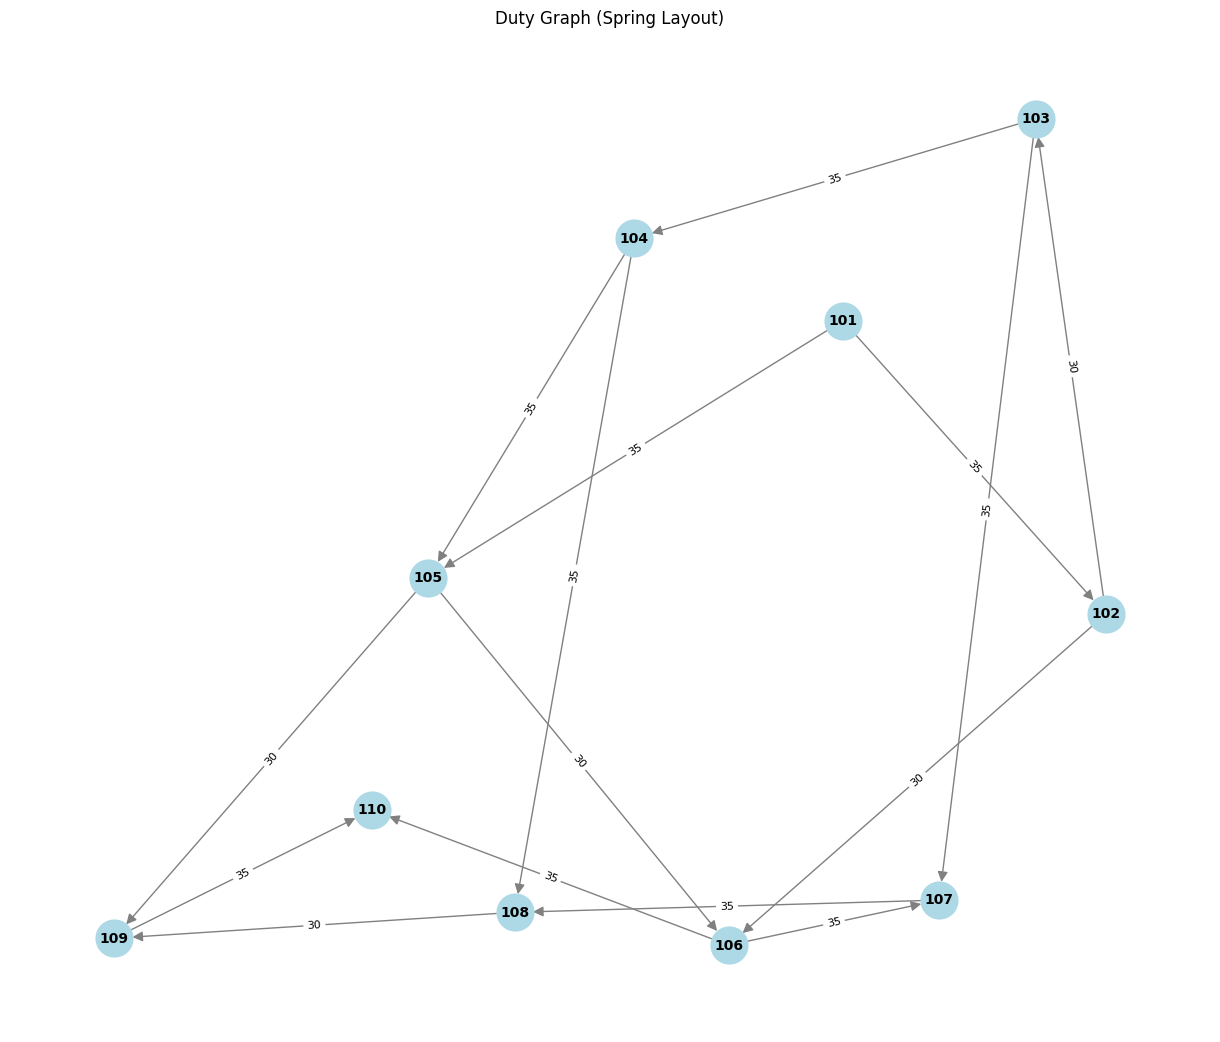

In [8]:
draw_duty_graph(graph)